# EEGMamba Fine-tuning on PhysioNet Motor Imagery Dataset

## Overview
Fine-tune EEGMamba model on PhysioNet Motor Imagery (MI) dataset for 4-class motor imagery classification.

## Workflow
1. Environment verification
2. Data preprocessing (optional - skip if already preprocessed)
3. Dataset loading & verification
4. Training configuration
5. Model fine-tuning
6. Training visualization
7. Model evaluation (pretrained vs fine-tuned)

## Dataset: PhysioNet EEG-MMI
- **Task**: 4-class motor imagery (left hand, right hand, feet, tongue)
- **Subjects**: 109 (70 train / 19 val / 20 test)
- **Channels**: 64 EEG channels @ 200 Hz
- **Epoch**: 4 seconds

## Step 1: Environment Setup

Verify all required packages are installed and working (PyTorch, MNE, Mamba-SSM, etc.).

In [1]:
# Verify all imports work correctly
print("🔍 Testing all critical imports...")

try:
    import torch
    import einops
    import numpy as np
    import scipy
    import sklearn
    import mne
    import lmdb
    print("✅ Basic packages imported successfully!")
    
    # Test the critical ones
    import mamba_ssm
    import causal_conv1d
    print("✅ Mamba-SSM ecosystem imported successfully!")
    
    # Print versions for debugging
    print(f"\n📋 Package versions:")
    print(f"   • PyTorch: {torch.__version__}")
    print(f"   • NumPy: {np.__version__}")
    print(f"   • MNE: {mne.__version__}")
    print(f"   • Mamba-SSM: {mamba_ssm.__version__}")
    
    print("\n🎉 All dependencies are working! Ready to proceed.")
    
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("\n🔧 If you see import errors:")
    print("1. Restart runtime (Runtime → Restart Runtime)")
    print("2. Re-run the installation cells")
    print("3. Check error messages for specific package issues")

🔍 Testing all critical imports...
✅ Basic packages imported successfully!


/home/mahmood/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Mamba-SSM ecosystem imported successfully!

📋 Package versions:
   • PyTorch: 2.5.1+cu121
   • NumPy: 1.26.2
   • MNE: 1.10.2
   • Mamba-SSM: 2.2.6.post3

🎉 All dependencies are working! Ready to proceed.


## Step 2: Data Preprocessing (Optional)

⚠️ **Skip this step if you already have the processed LMDB database.**

Run this only if you have raw PhysioNet EDF files. The preprocessing pipeline:
- Loads raw EDF files → Selects 64 channels → Filters & resamples to 200 Hz
- Extracts 4-second epochs → Reshapes data → Saves to LMDB database

Set `RUN_PREPROCESSING = True` to execute.

In [2]:
# PhysioNet-MI Data Preprocessing Script
# Run this only if you need to preprocess raw data

import os
import lmdb
import pickle
import numpy as np
import mne
from tqdm import tqdm

# Configuration
tasks = ['04', '06', '08', '10', '12', '14']  # Motor imagery tasks
root_dir = 'data/raw_motor_movement_Imagery/files'
output_db_path = 'data/'

print("🔧 PhysioNet-MI Preprocessing Configuration:")
print(f"📂 Raw data path: {root_dir}")
print(f"💾 Output database: {output_db_path}")
print(f"🎯 Tasks: {tasks}")

# Check if raw data exists
if not os.path.exists(root_dir):
    print("❌ Raw data directory not found!")
    print("Please ensure PhysioNet data is downloaded to the specified path.")
else:
    print("✅ Raw data directory found!")
    
    # List available subjects
    files = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    files = sorted(files)
    print(f"📊 Found {len(files)} subjects: {files[:5]}...{files[-5:]}")
    
    # Split subjects
    files_dict = {
        'train': files[:70],
        'val': files[70:89], 
        'test': files[89:109],
    }
    
    print(f"📈 Data split: Train={len(files_dict['train'])}, Val={len(files_dict['val'])}, Test={len(files_dict['test'])}")

# Set this to True only if you want to run preprocessing
RUN_PREPROCESSING = False

if RUN_PREPROCESSING:
    print("\n🚀 Starting preprocessing...")
else:
    print("\n⏸️ Preprocessing skipped. Set RUN_PREPROCESSING=True to run.")

🔧 PhysioNet-MI Preprocessing Configuration:
📂 Raw data path: data/raw_motor_movement_Imagery/files
💾 Output database: data/
🎯 Tasks: ['04', '06', '08', '10', '12', '14']
✅ Raw data directory found!
📊 Found 109 subjects: ['S001', 'S002', 'S003', 'S004', 'S005']...['S105', 'S106', 'S107', 'S108', 'S109']
📈 Data split: Train=70, Val=19, Test=20

⏸️ Preprocessing skipped. Set RUN_PREPROCESSING=True to run.


In [3]:
# Actual preprocessing implementation (only runs if enabled above)
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings
if RUN_PREPROCESSING and os.path.exists(root_dir):
    print("🔄 Running preprocessing...")
    
    # EEG channel selection (64 channels)
    selected_channels = [
        'Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 
        'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 
        'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 
        'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 
        'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 
        'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 
        'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 
        'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..'
    ]
    
    # Initialize LMDB database
    db = lmdb.open(output_db_path, map_size=4614542346)
    dataset = {'train': [], 'val': [], 'test': []}
    
    # Process each split
    for split_name, file_list in files_dict.items():
        print(f"\n📊 Processing {split_name} set ({len(file_list)} subjects)...")
        
        for file in tqdm(file_list, desc=f"{split_name}"):
            for task in tasks:
                try:
                    # Load EEG file
                    file_path = os.path.join(root_dir, file, f'{file}R{task}.edf')
                    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
                    
                    # Preprocessing pipeline
                    raw.pick_channels(selected_channels, ordered=True)
                    if len(raw.info['bads']) > 0:
                        raw.interpolate_bads()
                    raw.set_eeg_reference(ref_channels='average')
                    raw.filter(l_freq=0.3, h_freq=None, verbose=False)
                    raw.notch_filter(60, verbose=False)
                    raw.resample(200, verbose=False)
                    
                    # Extract epochs
                    events_from_annot, event_dict = mne.events_from_annotations(raw, verbose=False)
                    epochs = mne.Epochs(raw, events_from_annot, event_dict, 
                                      tmin=0, tmax=4-1.0/raw.info['sfreq'], 
                                      baseline=None, preload=True, verbose=False)
                    
                    # Get data and reshape
                    data = epochs.get_data(units='uV')[:, :, -800:]  # Last 4 seconds at 200Hz
                    events = epochs.events[:, 2]
                    
                    # Reshape to (batch, channels, time_segments, samples_per_segment)
                    bz, ch_nums, _ = data.shape
                    data = data.reshape(bz, ch_nums, 4, 200)
                    
                    # Save to LMDB
                    for i, (sample, event) in enumerate(zip(data, events)):
                        if event != 1:  # Skip rest events
                            sample_key = f'{file}R{task}-{i}'
                            data_dict = {
                                'sample': sample,
                                'label': event - 2 if task in ['04', '08', '12'] else event
                            }
                            txn = db.begin(write=True)
                            txn.put(key=sample_key.encode(), value=pickle.dumps(data_dict))
                            txn.commit()
                            dataset[split_name].append(sample_key)
                            
                except Exception as e:
                    print(f"❌ Error processing {file}R{task}: {str(e)[:100]}...")
                    continue
    
    # Save dataset keys
    txn = db.begin(write=True)
    txn.put(key='__keys__'.encode(), value=pickle.dumps(dataset))
    txn.commit()
    db.close()
    
    print(f"\n✅ Preprocessing complete!")
    print(f"📊 Dataset saved with {sum(len(v) for v in dataset.values())} total samples")
    for split, samples in dataset.items():
        print(f"   {split}: {len(samples)} samples")
        
else:
    if not RUN_PREPROCESSING:
        print("⏸️ Preprocessing skipped")
    else:
        print("❌ Cannot run preprocessing - raw data path not found")

⏸️ Preprocessing skipped


In [4]:
# Verify preprocessed data exists
import os
import pickle

# Check for processed data in Google Drive
data_path = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
print(f"🔍 Checking for processed data at: {data_path}")

if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"✅ Processed data directory found!")
    print(f"📁 Contents: {files}")
    
    # Check for LMDB database files
    if 'data.mdb' in files and 'lock.mdb' in files:
        print("✅ LMDB database files present - data is ready for training!")
        
        # Get database info
        import lmdb
        db = lmdb.open(data_path, readonly=True)
        with db.begin() as txn:
            try:
                keys_data = txn.get('__keys__'.encode())
                if keys_data:
                    dataset_keys = pickle.loads(keys_data)
                    print(f"📊 Dataset splits:")
                    for split, samples in dataset_keys.items():
                        print(f"   {split}: {len(samples)} samples")
                    total_samples = sum(len(v) for v in dataset_keys.values())
                    print(f"📈 Total samples: {total_samples}")
                else:
                    print("⚠️ Dataset keys not found in database")
            except:
                print("⚠️ Could not read dataset keys")
        db.close()
    else:
        print("❌ LMDB database files missing - preprocessing needed")
        print("💡 Set RUN_PREPROCESSING=True in the previous cell to create the database")
else:
    print("❌ Processed data directory not found")
    print("💡 Options:")
    print("   1. Set RUN_PREPROCESSING=True above to preprocess data")
    print("   2. Check if the path is correct")
    print("   3. Upload preprocessed data to Google Drive")

🔍 Checking for processed data at: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
✅ Processed data directory found!
📁 Contents: ['lock.mdb', 'data.mdb']
✅ LMDB database files present - data is ready for training!
📊 Dataset splits:
   train: 6300 samples
   val: 1734 samples
   test: 1758 samples
📈 Total samples: 9792


## Step 3: Test Dataset Loading

Verify the LMDB database loads correctly and check data shape/labels.

In [5]:
print("🧪 Testing EEGMamba dataset loader...")

try:
    from datasets.physio_dataset import LoadDataset
    
    # Create test parameters for dataset loading
    class TestParams:
        def __init__(self):
            self.datasets_dir = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
            self.batch_size = 8
    
    # Initialize dataset loader
    test_params = TestParams()
    print(f"📂 Loading dataset from: {test_params.datasets_dir}")
    
    dataset_loader = LoadDataset(test_params)
    data_loaders = dataset_loader.get_data_loader()
    
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Available data splits: {list(data_loaders.keys())}")
    
    # Test data loading
    for split_name, data_loader in data_loaders.items():
        print(f"\n🔍 Examining {split_name.upper()} set:")
        print(f"   Number of batches: {len(data_loader)}")
        
        # Get first batch to examine data structure
        for batch_idx, (data, labels) in enumerate(data_loader):
            print(f"   ✅ Batch {batch_idx + 1} loaded successfully")
            print(f"   📊 Data shape: {data.shape}")
            print(f"   🎯 Labels shape: {labels.shape}")
            print(f"   📈 Data type: {data.dtype}")
            print(f"   📉 Data range: [{data.min():.3f}, {data.max():.3f}]")
            
            # Check labels
            unique_labels = torch.unique(labels).tolist()
            print(f"   🏷️ Unique labels: {unique_labels}")
            print(f"   📝 Label meanings: 0=left_hand, 1=right_hand, 2=feet, 3=tongue")
            break  # Only examine first batch
        break  # Only examine first split for testing
        
    print("\n🎉 Dataset loading test completed successfully!")
    
except Exception as e:
    print(f"❌ Error testing dataset loader: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Make sure preprocessed data exists")
    print("2. Check the datasets_dir path")
    print("3. Verify LMDB database integrity")

🧪 Testing EEGMamba dataset loader...
📂 Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
✅ Dataset loaded successfully!
📊 Available data splits: ['train', 'val', 'test']

🔍 Examining TRAIN set:
   Number of batches: 788
   ✅ Batch 1 loaded successfully
   📊 Data shape: torch.Size([8, 64, 4, 200])
   🎯 Labels shape: torch.Size([8])
   📈 Data type: torch.float32
   📉 Data range: [-8.201, 16.395]
   🏷️ Unique labels: [0, 1, 2, 3]
   📝 Label meanings: 0=left_hand, 1=right_hand, 2=feet, 3=tongue

🎉 Dataset loading test completed successfully!


In [6]:
import torch
import matplotlib.pyplot as plt

print("📊 Detailed Data Analysis")

if 'data_loaders' in locals():
    for split_name, data_loader in data_loaders.items():
        print(f"\n--- {split_name.upper()} SET ANALYSIS ---")
        
        all_labels = []
        batch_count = 0
        sample_count = 0
        
        # Analyze several batches
        for batch_idx, (data, labels) in enumerate(data_loader):
            batch_count += 1
            sample_count += data.shape[0]
            all_labels.extend(labels.tolist())
            
            if batch_idx == 0:  # Detailed analysis of first batch
                print(f"📐 Data tensor shape: {data.shape}")
                print(f"   • Batch size: {data.shape[0]}")
                print(f"   • Channels: {data.shape[1]}")
                print(f"   • Time segments: {data.shape[2]}")
                print(f"   • Samples per segment: {data.shape[3]}")
                print(f"   • Total time points: {data.shape[2] * data.shape[3]}")
                print(f"   • Time duration: {data.shape[2] * data.shape[3] / 200:.1f} seconds (at 200 Hz)")
                
            # Don't load all data to save memory
            if batch_idx >= 5:  # Analyze first 5 batches only
                break
                
        # Label distribution
        unique_labels, counts = torch.unique(torch.tensor(all_labels), return_counts=True)
        print(f"\n🏷️ Label Distribution (first {batch_count} batches):")
        label_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
        for label, count in zip(unique_labels.tolist(), counts.tolist()):
            if label < len(label_names):
                print(f"   {label_names[label]} (class {label}): {count} samples")
        
        print(f"📊 Total samples analyzed: {len(all_labels)}")
        
        # Only analyze first split to save time
        break
        
    print("\n✅ Data analysis completed!")
else:
    print("❌ No data loaders available. Please run the previous cell first.")

📊 Detailed Data Analysis

--- TRAIN SET ANALYSIS ---
📐 Data tensor shape: torch.Size([8, 64, 4, 200])
   • Batch size: 8
   • Channels: 64
   • Time segments: 4
   • Samples per segment: 200
   • Total time points: 800
   • Time duration: 4.0 seconds (at 200 Hz)

🏷️ Label Distribution (first 6 batches):
   Left Hand (class 0): 14 samples
   Right Hand (class 1): 10 samples
   Feet (class 2): 12 samples
   Tongue (class 3): 12 samples
📊 Total samples analyzed: 48

✅ Data analysis completed!


## Step 4: Fine-tuning Configuration

Configure training hyperparameters:
- **Epochs**: 50 | **Batch size**: 32 | **Learning rate**: 1e-4
- **Optimizer**: AdamW with weight decay 5e-2
- **Pretrained weights**: Optional initialization from pretrained model

In [7]:
# EEGMamba Training Configuration
print("⚙️ EEGMamba Training Configuration")

# Dataset and paths
DATASET_NAME = "PhysioNet-MI"
DATASETS_DIR = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
MODEL_DIR = "./results/physio_models"
PRETRAINED_WEIGHTS = "pretrained_weights/pretrained_weights.pth"

# Model parameters
NUM_CLASSES = 4  # Motor imagery classes: left hand, right hand, feet, tongue
CLASSIFIER_TYPE = "all_patch_reps"  # EEGMamba classifier type

# Training hyperparameters
EPOCHS = 50  
BATCH_SIZE = 32 
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-2
CUDA_DEVICE = 0

# Advanced options
OPTIMIZER = "AdamW"
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1
USE_PRETRAINED = True

print("📋 Configuration Summary:")
print(f"   🎯 Dataset: {DATASET_NAME}")
print(f"   📂 Data path: {DATASETS_DIR}")
print(f"   🏷️ Classes: {NUM_CLASSES}")
print(f"   🏃 Epochs: {EPOCHS}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   📈 Learning rate: {LEARNING_RATE}")
print(f"   💾 Model save dir: {MODEL_DIR}")
print(f"   🎭 Use pretrained: {USE_PRETRAINED}")

# Verify pretrained weights exist
if USE_PRETRAINED:
    if os.path.exists(PRETRAINED_WEIGHTS):
        print(f"   ✅ Pretrained weights found: {PRETRAINED_WEIGHTS}")
    else:
        print(f"   ⚠️ Pretrained weights not found: {PRETRAINED_WEIGHTS}")
        print("   💡 Will train from scratch or download weights")

# Create results directory
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"   📁 Results directory ready: {MODEL_DIR}")

⚙️ EEGMamba Training Configuration
📋 Configuration Summary:
   🎯 Dataset: PhysioNet-MI
   📂 Data path: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
   🏷️ Classes: 4
   🏃 Epochs: 50
   📦 Batch size: 32
   📈 Learning rate: 0.0001
   💾 Model save dir: ./results/physio_models
   🎭 Use pretrained: True
   ⚠️ Pretrained weights not found: pretrained_weights/pretrained_weights.pth
   💡 Will train from scratch or download weights
   📁 Results directory ready: ./results/physio_models


In [8]:
# Quick environment check before training
print("🔍 Pre-training Environment Check")

# Check GPU availability
if torch.cuda.is_available():
    print(f"✅ CUDA available: {torch.cuda.get_device_name(0)}")
    print(f"   GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ CUDA not available - training will be slow on CPU")

# Check key files
key_files = {
    'finetune_main.py': 'Main training script',
    'models/': 'Model definitions',
    'datasets/': 'Dataset loaders',
    'pretrained_weights/': 'Pretrained weights'
}

for file_path, description in key_files.items():
    if os.path.exists(file_path):
        print(f"✅ {description}: {file_path}")
    else:
        print(f"❌ Missing {description}: {file_path}")

# Check if we can import the model
try:
    from models.model_for_physio import Model
    print("✅ PhysioNet model import successful")
except Exception as e:
    print(f"❌ Model import failed: {e}")

print("\n🚀 Ready for training!")

🔍 Pre-training Environment Check
✅ CUDA available: NVIDIA RTX A4000
   GPU memory: 16.8 GB
✅ Main training script: finetune_main.py
✅ Model definitions: models/
✅ Dataset loaders: datasets/
✅ Pretrained weights: pretrained_weights/
✅ PhysioNet model import successful

🚀 Ready for training!


## Step 5: Run Fine-tuning

Execute training on PhysioNet-MI dataset. Training process:
- Trains for configured epochs with validation after each epoch
- Saves best model checkpoint based on validation accuracy
- Logs metrics to `training_log.json`
- Tests final model on test set

⏱️ **Duration**: ~30-60 minutes for 50 epochs (hardware dependent)

In [9]:
# Quick test command
test_command = f"""
python finetune_main.py \
    --downstream_dataset {DATASET_NAME} \
    --datasets_dir {DATASETS_DIR} \
    --num_of_classes {NUM_CLASSES} \
    --model_dir {MODEL_DIR}_test \
    --epochs 50 \
    --batch_size 32 \
    --lr {LEARNING_RATE} \
    --weight_decay {WEIGHT_DECAY} \
    --cuda {CUDA_DEVICE} \
    --use_pretrained_weights True \
    --foundation_dir {PRETRAINED_WEIGHTS}
"""

print("Quick Test Command:")
print(test_command.strip())
print("\n📝 Copy and run this command in terminal to test the setup!")

Quick Test Command:
python finetune_main.py     --downstream_dataset PhysioNet-MI     --datasets_dir /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average     --num_of_classes 4     --model_dir ./results/physio_models_test     --epochs 50     --batch_size 32     --lr 0.0001     --weight_decay 0.05     --cuda 0     --use_pretrained_weights True     --foundation_dir pretrained_weights/pretrained_weights.pth

📝 Copy and run this command in terminal to test the setup!


In [17]:
!python finetune_main.py     --downstream_dataset PhysioNet-MI     --datasets_dir /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average     --num_of_classes 4     --model_dir ./results/physio_models_test     --epochs 50     --batch_size 32     --lr 0.0001     --weight_decay 0.05     --cuda 0     --use_pretrained_weights True     --foundation_dir pretrained_weights/pretrained_weights.pth


Namespace(seed=3407, cuda=0, epochs=50, batch_size=32, lr=0.0001, weight_decay=0.05, optimizer='AdamW', clip_value=1, dropout=0.1, classifier='all_patch_reps', downstream_dataset='PhysioNet-MI', datasets_dir='/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average', num_of_classes=4, model_dir='./results/physio_models_test', num_workers=16, label_smoothing=0.1, multi_lr=True, frozen=False, use_pretrained_weights=True, foundation_dir='pretrained_weights/pretrained_weights.pth')
The downstream dataset is PhysioNet-MI
6300 1734 1758
9792
/home/mahmood/HosseinDahaei/Codes/EEGMamba/models/model_for_physio.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

## Step 6: Visualize Training Progress

Plot training metrics (loss, accuracy, F1, kappa) from the saved log file.

🔍 Looking for training log...
✅ Found log file: ./results/physio_models_test/training_log.json
📂 Loading training log from: ./results/physio_models_test/training_log.json
✅ Log loaded successfully!
📊 Total epochs trained: 50


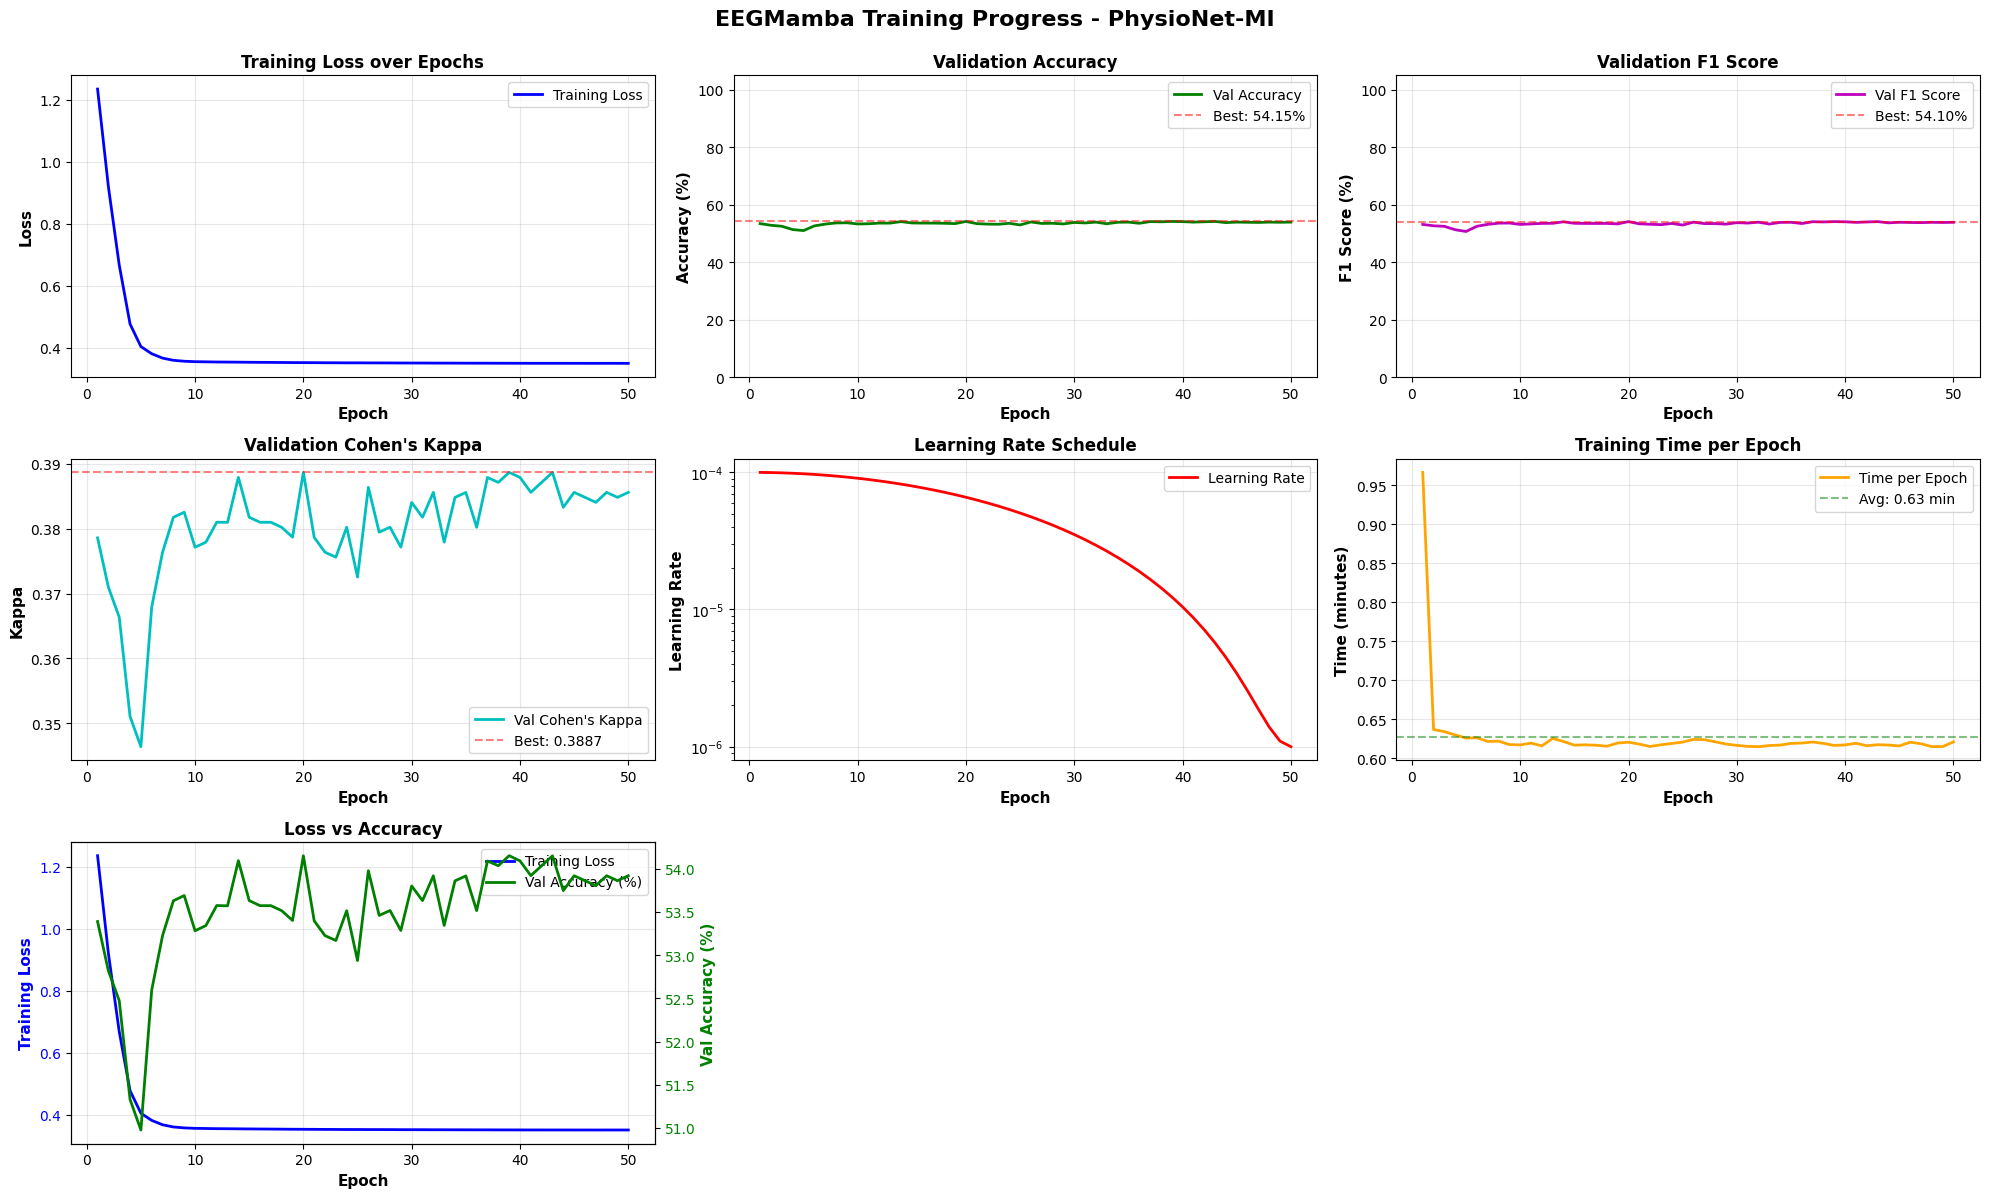


📊 TRAINING SUMMARY

🕒 Training Duration:
   Total epochs: 50
   Total time: 31.33 minutes (0.52 hours)
   Avg time per epoch: 0.63 minutes

📈 Training Loss:
   Initial: 1.23511
   Final: 0.35019
   Best (min): 0.35016
   Reduction: 71.65%

🎯 Validation Accuracy:
   Initial: 53.39%
   Final: 53.92%
   Best: 54.15%
   Best epoch: 39
   Improvement: +0.53 percentage points

📊 Validation Kappa:
   Initial: 0.3786
   Final: 0.3856
   Best: 0.3887
   Best epoch: 39

📈 Validation F1 Score:
   Initial: 53.11%
   Final: 53.85%
   Best: 54.10%
   Best epoch: 43

🏆 TEST SET RESULTS (Best Model):
   Best epoch: 39
   Accuracy: 58.13%
   Kappa: 0.4410
   F1 Score: 57.97%




In [18]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_training_progress(log_file_path):
    """
    Plot training progress from the saved training log
    
    Args:
        log_file_path: Path to the training_log.json file
    """
    
    # Check if log file exists
    if not os.path.exists(log_file_path):
        print(f"❌ Training log not found at: {log_file_path}")
        print("💡 Please make sure training has completed and the log file was created")
        return
    
    # Load training log
    print(f"📂 Loading training log from: {log_file_path}")
    with open(log_file_path, 'r') as f:
        history = json.load(f)
    
    print(f"✅ Log loaded successfully!")
    print(f"📊 Total epochs trained: {len(history['train_loss'])}")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Training Loss
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss')
    ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax1.set_title('Training Loss over Epochs', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # 2. Validation Accuracy
    if history['val_acc']:
        ax2 = plt.subplot(3, 3, 2)
        ax2.plot(epochs, [acc * 100 for acc in history['val_acc']], 'g-', linewidth=2, label='Val Accuracy')
        ax2.axhline(y=max(history['val_acc']) * 100, color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["val_acc"])*100:.2f}%')
        ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Validation Accuracy', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(fontsize=10)
        ax2.set_ylim([0, 105])
    
    # 3. Validation F1 Score (if available)
    if history.get('val_f1') and any(history['val_f1']):
        ax3 = plt.subplot(3, 3, 3)
        ax3.plot(epochs, [f1 * 100 for f1 in history['val_f1']], 'm-', linewidth=2, label='Val F1 Score')
        ax3.axhline(y=max(history['val_f1']) * 100, color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["val_f1"])*100:.2f}%')
        ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax3.set_ylabel('F1 Score (%)', fontsize=11, fontweight='bold')
        ax3.set_title('Validation F1 Score', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.legend(fontsize=10)
        ax3.set_ylim([0, 105])
    
    # 4. Validation Kappa (if available)
    if history.get('val_kappa') and any(history['val_kappa']):
        ax4 = plt.subplot(3, 3, 4)
        ax4.plot(epochs, history['val_kappa'], 'c-', linewidth=2, label='Val Cohen\'s Kappa')
        ax4.axhline(y=max(history['val_kappa']), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(history["val_kappa"]):.4f}')
        ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Kappa', fontsize=11, fontweight='bold')
        ax4.set_title('Validation Cohen\'s Kappa', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend(fontsize=10)
    
    # 5. Learning Rate
    if history['learning_rate']:
        ax5 = plt.subplot(3, 3, 5)
        ax5.plot(epochs, history['learning_rate'], 'r-', linewidth=2, label='Learning Rate')
        ax5.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax5.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
        ax5.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3)
        ax5.legend(fontsize=10)
        ax5.set_yscale('log')
    
    # 6. Epoch Time
    if history['epoch_time']:
        ax6 = plt.subplot(3, 3, 6)
        ax6.plot(epochs, history['epoch_time'], 'orange', linewidth=2, label='Time per Epoch')
        ax6.axhline(y=np.mean(history['epoch_time']), color='g', linestyle='--', alpha=0.5, label=f'Avg: {np.mean(history["epoch_time"]):.2f} min')
        ax6.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax6.set_ylabel('Time (minutes)', fontsize=11, fontweight='bold')
        ax6.set_title('Training Time per Epoch', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        ax6.legend(fontsize=10)
    
    # 7. Combined Metrics (Loss + Accuracy)
    ax7 = plt.subplot(3, 3, 7)
    ax7_twin = ax7.twinx()
    
    line1 = ax7.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss')
    if history['val_acc']:
        line2 = ax7_twin.plot(epochs, [acc * 100 for acc in history['val_acc']], 'g-', linewidth=2, label='Val Accuracy (%)')
    
    ax7.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Training Loss', fontsize=11, fontweight='bold', color='b')
    ax7_twin.set_ylabel('Val Accuracy (%)', fontsize=11, fontweight='bold', color='g')
    ax7.set_title('Loss vs Accuracy', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    ax7.tick_params(axis='y', labelcolor='b')
    ax7_twin.tick_params(axis='y', labelcolor='g')
    
    # Combine legends
    lines = line1
    if history['val_acc']:
        lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax7.legend(lines, labels, loc='upper right', fontsize=10)
    
    # 8. Binary classification metrics (if available)
    if history.get('val_roc_auc') and any(history['val_roc_auc']):
        ax8 = plt.subplot(3, 3, 8)
        ax8.plot(epochs, [auc * 100 for auc in history['val_roc_auc']], 'purple', linewidth=2, label='ROC AUC')
        if history.get('val_pr_auc') and any(history['val_pr_auc']):
            ax8.plot(epochs, [auc * 100 for auc in history['val_pr_auc']], 'brown', linewidth=2, label='PR AUC')
        ax8.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax8.set_ylabel('AUC (%)', fontsize=11, fontweight='bold')
        ax8.set_title('Validation AUC Metrics', fontsize=12, fontweight='bold')
        ax8.grid(True, alpha=0.3)
        ax8.legend(fontsize=10)
        ax8.set_ylim([0, 105])
    
    # 9. Regression metrics (if available)
    if history.get('val_r2') and any(history['val_r2']):
        ax9 = plt.subplot(3, 3, 9)
        ax9.plot(epochs, history['val_r2'], 'teal', linewidth=2, label='R² Score')
        if history.get('val_corrcoef') and any(history['val_corrcoef']):
            ax9.plot(epochs, history['val_corrcoef'], 'navy', linewidth=2, label='Correlation Coef')
        ax9.set_xlabel('Epoch', fontsize=11, fontweight='bold')
        ax9.set_ylabel('Score', fontsize=11, fontweight='bold')
        ax9.set_title('Validation Regression Metrics', fontsize=12, fontweight='bold')
        ax9.grid(True, alpha=0.3)
        ax9.legend(fontsize=10)
    
    plt.suptitle('EEGMamba Training Progress - PhysioNet-MI', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("📊 TRAINING SUMMARY")
    print("="*80)
    print(f"\n🕒 Training Duration:")
    print(f"   Total epochs: {len(history['train_loss'])}")
    print(f"   Total time: {sum(history['epoch_time']):.2f} minutes ({sum(history['epoch_time'])/60:.2f} hours)")
    print(f"   Avg time per epoch: {np.mean(history['epoch_time']):.2f} minutes")
    
    print(f"\n📈 Training Loss:")
    print(f"   Initial: {history['train_loss'][0]:.5f}")
    print(f"   Final: {history['train_loss'][-1]:.5f}")
    print(f"   Best (min): {min(history['train_loss']):.5f}")
    print(f"   Reduction: {(1 - history['train_loss'][-1]/history['train_loss'][0])*100:.2f}%")
    
    if history['val_acc']:
        print(f"\n🎯 Validation Accuracy:")
        print(f"   Initial: {history['val_acc'][0]*100:.2f}%")
        print(f"   Final: {history['val_acc'][-1]*100:.2f}%")
        print(f"   Best: {max(history['val_acc'])*100:.2f}%")
        print(f"   Best epoch: {history['val_acc'].index(max(history['val_acc'])) + 1}")
        print(f"   Improvement: {(history['val_acc'][-1] - history['val_acc'][0])*100:+.2f} percentage points")
    
    if history.get('val_kappa') and any(history['val_kappa']):
        print(f"\n📊 Validation Kappa:")
        print(f"   Initial: {history['val_kappa'][0]:.4f}")
        print(f"   Final: {history['val_kappa'][-1]:.4f}")
        print(f"   Best: {max(history['val_kappa']):.4f}")
        print(f"   Best epoch: {history['val_kappa'].index(max(history['val_kappa'])) + 1}")
    
    if history.get('val_f1') and any(history['val_f1']):
        print(f"\n📈 Validation F1 Score:")
        print(f"   Initial: {history['val_f1'][0]*100:.2f}%")
        print(f"   Final: {history['val_f1'][-1]*100:.2f}%")
        print(f"   Best: {max(history['val_f1'])*100:.2f}%")
        print(f"   Best epoch: {history['val_f1'].index(max(history['val_f1'])) + 1}")
    
    # Test results
    if history.get('test_results'):
        print(f"\n🏆 TEST SET RESULTS (Best Model):")
        test_res = history['test_results']
        print(f"   Best epoch: {test_res.get('best_epoch', 'N/A')}")
        
        if 'acc' in test_res:
            print(f"   Accuracy: {test_res['acc']*100:.2f}%")
        if 'kappa' in test_res:
            print(f"   Kappa: {test_res['kappa']:.4f}")
        if 'f1' in test_res:
            print(f"   F1 Score: {test_res['f1']*100:.2f}%")
        if 'roc_auc' in test_res:
            print(f"   ROC AUC: {test_res['roc_auc']*100:.2f}%")
        if 'pr_auc' in test_res:
            print(f"   PR AUC: {test_res['pr_auc']*100:.2f}%")
        if 'r2' in test_res:
            print(f"   R² Score: {test_res['r2']:.4f}")
        if 'corrcoef' in test_res:
            print(f"   Correlation: {test_res['corrcoef']:.4f}")
    
    print("\n" + "="*80 + "\n")
    
    return history


# Example usage - modify the path to your training log
LOG_FILE = "./results/physio_models_test/training_log.json"

print("🔍 Looking for training log...")
if os.path.exists(LOG_FILE):
    print(f"✅ Found log file: {LOG_FILE}")
    history = plot_training_progress(LOG_FILE)
else:
    print(f"⚠️ Log file not found at: {LOG_FILE}")
    print("\n💡 Alternative locations to check:")
    
    # Search for training logs in common locations
    possible_dirs = [
        "./results/physio_models",
        "./results/physio_models_test",
        "./results"
    ]
    
    found_logs = []
    for search_dir in possible_dirs:
        if os.path.exists(search_dir):
            for root, dirs, files in os.walk(search_dir):
                if 'training_log.json' in files:
                    found_logs.append(os.path.join(root, 'training_log.json'))
    
    if found_logs:
        print("\n📂 Found training logs:")
        for i, log_path in enumerate(found_logs, 1):
            print(f"   {i}. {log_path}")
        print(f"\n💡 To visualize a specific log, run:")
        print(f"   history = plot_training_progress('{found_logs[0]}')")
    else:
        print("   No training logs found yet.")
        print("   Training logs will be created automatically after running the finetuning process.")


## Unified Model Evaluation Function

Evaluate both pretrained (zero-shot) and fine-tuned models using the same function.

In [26]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, cohen_kappa_score
import glob
import os

def evaluate_model(model_type='pretrained', model_path=None, data_path=None, batch_size=32, cuda_device=0, verbose=True):
    """
    Unified evaluation function for both pretrained and finetuned EEGMamba models.
    
    Args:
        model_type (str): Either 'pretrained' or 'finetuned'
                         - 'pretrained': Load pretrained weights from foundation_dir
                         - 'finetuned': Load finetuned model checkpoint from model_path
        model_path (str): Path to the finetuned model checkpoint. 
                         If None and model_type='finetuned', will auto-find best model.
                         Ignored when model_type='pretrained'.
        data_path (str): Path to the dataset LMDB directory. 
                        If None, uses default PhysioNet-MI path.
        batch_size (int): Batch size for evaluation (default: 32)
        cuda_device (int): CUDA device number (default: 0)
        verbose (bool): Whether to print detailed results (default: True)
    
    Returns:
        dict: Dictionary containing results for each data split (train, val, test)
              Each split contains: balanced_accuracy, standard_accuracy, f1, kappa, 
              confusion_matrix, num_samples, predictions, probabilities, ground_truth
    
    Example:
        # Evaluate pretrained model
        pretrained_results = evaluate_model(model_type='pretrained')
        
        # Evaluate finetuned model (auto-find best)
        finetuned_results = evaluate_model(model_type='finetuned')
        
        # Evaluate specific finetuned model
        results = evaluate_model(
            model_type='finetuned',
            model_path='./results/physio_models/epoch30_acc_0.85.pth'
        )
    """
    
    if verbose:
        print("="*80)
        print(f"🧪 EEGMamba Model Evaluation - {model_type.upper()} Model")
        print("="*80)
    
    # Import required modules
    from datasets.physio_dataset import LoadDataset
    from models.model_for_physio import Model
    
    # Set default data path if not provided
    if data_path is None:
        data_path = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
    
    # Create parameters object
    class EvalParams:
        def __init__(self):
            self.datasets_dir = data_path
            self.batch_size = batch_size
            self.num_workers = 8
            self.downstream_dataset = 'PhysioNet-MI'
            self.num_of_classes = 4
            self.use_pretrained_weights = (model_type == 'pretrained')
            self.foundation_dir = "pretrained_weights/pretrained_weights.pth"
            self.classifier = 'all_patch_reps'
            self.dropout = 0.1
            self.seed = 3407
            self.cuda = cuda_device
    
    params = EvalParams()
    
    # Set device
    device = torch.device(f'cuda:{params.cuda}' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print(f"Device: {device}")
        print(f"Model Type: {model_type}")
    
    # Handle finetuned model path
    if model_type == 'finetuned':
        if model_path is None:
            if verbose:
                print("\n🔍 Searching for best finetuned model checkpoint...")
            
            model_dirs = ["./results/physio_models_test", "./results/physio_models"]
            best_model_path = None
            best_acc = -1
            
            for model_dir in model_dirs:
                if os.path.exists(model_dir):
                    model_files = glob.glob(os.path.join(model_dir, "*.pth"))
                    
                    for mf in model_files:
                        try:
                            filename = os.path.basename(mf)
                            if 'acc_' in filename:
                                acc_str = filename.split('acc_')[1].split('_')[0]
                                acc = float(acc_str)
                                if acc > best_acc:
                                    best_acc = acc
                                    best_model_path = mf
                        except:
                            continue
            
            if best_model_path is None:
                raise FileNotFoundError("❌ No trained model found! Please train the model first or specify model_path.")
            
            model_path = best_model_path
            if verbose:
                print(f"✅ Found best model: {os.path.basename(model_path)}")
                print(f"   Reported accuracy: {best_acc*100:.2f}%")
        else:
            if verbose:
                print(f"📂 Using specified model: {os.path.basename(model_path)}")
    
    # Load dataset
    if verbose:
        print(f"\n📂 Loading dataset from: {params.datasets_dir}")
    
    load_dataset = LoadDataset(params)
    data_loaders = load_dataset.get_data_loader()
    
    if verbose:
        print(f"✅ Available splits: {list(data_loaders.keys())}")
    
    # Load model architecture
    if verbose:
        print(f"\n🏗️ Loading model architecture...")
    
    model = Model(params)
    model = model.to(device)
    
    # Load weights based on model type
    if model_type == 'finetuned':
        if verbose:
            print(f"📥 Loading finetuned weights from: {os.path.basename(model_path)}")
        
        try:
            checkpoint = torch.load(model_path, map_location=device)
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
                elif 'state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['state_dict'])
                else:
                    model.load_state_dict(checkpoint)
            else:
                model.load_state_dict(checkpoint)
            
            if verbose:
                print("✅ Finetuned weights loaded successfully!")
        except Exception as e:
            raise RuntimeError(f"❌ Error loading finetuned weights: {e}")
    else:
        if verbose:
            print(f"📥 Using pretrained weights (loaded during model initialization)")
            print("✅ Pretrained weights loaded successfully!")
    
    model.eval()
    
    # Evaluate on each split
    results = {}
    
    for split_name in ['train', 'val', 'test']:
        if split_name not in data_loaders:
            continue
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"🔬 Evaluating on {split_name.upper()} set")
            print(f"{'='*80}")
        
        truths = []
        preds = []
        pred_probs = []
        
        with torch.no_grad():
            iterator = tqdm(data_loaders[split_name], desc=f"Testing {split_name}") if verbose else data_loaders[split_name]
            for x, y in iterator:
                x = x.to(device)
                y = y.to(device)
                
                # Get model predictions
                pred = model(x)
                pred_y = torch.max(pred, dim=-1)[1]
                pred_prob = torch.softmax(pred, dim=-1)
                
                truths.extend(y.cpu().numpy().tolist())
                preds.extend(pred_y.cpu().numpy().tolist())
                pred_probs.extend(pred_prob.cpu().numpy().tolist())
        
        # Calculate metrics
        truths = np.array(truths)
        preds = np.array(preds)
        pred_probs = np.array(pred_probs)
        
        balanced_acc = balanced_accuracy_score(truths, preds)
        standard_acc = np.mean(truths == preds)
        f1 = f1_score(truths, preds, average='weighted')
        kappa = cohen_kappa_score(truths, preds)
        cm = confusion_matrix(truths, preds)
        
        results[split_name] = {
            'balanced_accuracy': balanced_acc,
            'standard_accuracy': standard_acc,
            'f1': f1,
            'kappa': kappa,
            'confusion_matrix': cm,
            'num_samples': len(truths),
            'predictions': preds,
            'probabilities': pred_probs,
            'ground_truth': truths
        }
        
        if verbose:
            # Print results
            print(f"\n📊 {split_name.upper()} Results:")
            print(f"  • Standard Accuracy: {standard_acc*100:.2f}%")
            print(f"  • Balanced Accuracy: {balanced_acc*100:.2f}%")
            print(f"  • F1 Score (Weighted): {f1*100:.2f}%")
            print(f"  • Cohen's Kappa: {kappa:.4f}")
            print(f"  • Total Samples: {len(truths)}")
            
            print(f"\n📋 Confusion Matrix:")
            print("           ", "  ".join([f"Pred-{i}" for i in range(cm.shape[1])]))
            for i, row in enumerate(cm):
                print(f"True-{i}:   ", "  ".join([f"{val:6d}" for val in row]))
            
            # Per-class metrics
            print(f"\n🎯 Per-Class Performance:")
            class_names = ['Left Hand (0)', 'Right Hand (1)', 'Feet (2)', 'Tongue (3)']
            for i, class_name in enumerate(class_names):
                if i < cm.shape[0] and cm[i, :].sum() > 0:
                    class_acc = cm[i, i] / cm[i, :].sum()
                    class_samples = cm[i, :].sum()
                    class_precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
                    class_f1 = 2 * (class_precision * class_acc) / (class_precision + class_acc) if (class_precision + class_acc) > 0 else 0
                    print(f"  {class_name:20s}: Acc={class_acc*100:6.2f}% | Prec={class_precision*100:6.2f}% | F1={class_f1*100:6.2f}% ({int(class_samples)} samples)")
    
    if verbose:
        # Summary table
        print(f"\n{'='*80}")
        print(f"📈 SUMMARY - {model_type.upper()} Model Performance")
        print(f"{'='*80}")
        if model_type == 'finetuned' and model_path:
            print(f"Model: {os.path.basename(model_path)}")
        print()
        print(f"{'Split':<10} {'Std Acc':<12} {'Bal Acc':<12} {'F1 Score':<12} {'Kappa':<10} {'Samples'}")
        print("-"*80)
        
        for split_name in ['train', 'val', 'test']:
            if split_name in results:
                r = results[split_name]
                print(f"{split_name.upper():<10} "
                      f"{r['standard_accuracy']*100:6.2f}%      "
                      f"{r['balanced_accuracy']*100:6.2f}%      "
                      f"{r['f1']*100:6.2f}%      "
                      f"{r['kappa']:6.4f}    "
                      f"{r['num_samples']}")
        
        print(f"{'='*80}\n")
    
    return results


# Print usage examples
print("✅ Unified evaluation function loaded!")
print("\n📖 Usage Examples:")
print("-" * 80)
print("# 1. Evaluate pretrained model (zero-shot)")
print("pretrained_results = evaluate_model(model_type='pretrained')")
print()
print("# 2. Evaluate finetuned model (auto-find best)")
print("finetuned_results = evaluate_model(model_type='finetuned')")
print()
print("# 3. Evaluate specific finetuned model")
print("results = evaluate_model(")
print("    model_type='finetuned',")
print("    model_path='./results/physio_models/epoch30_acc_0.85.pth'")
print(")")
print()
print("# 4. Custom settings")
print("results = evaluate_model(")
print("    model_type='pretrained',")
print("    data_path='/custom/path/to/data',")
print("    batch_size=64,")
print("    cuda_device=0,")
print("    verbose=True")
print(")")
print("-" * 80)

✅ Unified evaluation function loaded!

📖 Usage Examples:
--------------------------------------------------------------------------------
# 1. Evaluate pretrained model (zero-shot)
pretrained_results = evaluate_model(model_type='pretrained')

# 2. Evaluate finetuned model (auto-find best)
finetuned_results = evaluate_model(model_type='finetuned')

# 3. Evaluate specific finetuned model
results = evaluate_model(
    model_type='finetuned',
    model_path='./results/physio_models/epoch30_acc_0.85.pth'
)

# 4. Custom settings
results = evaluate_model(
    model_type='pretrained',
    data_path='/custom/path/to/data',
    batch_size=64,
    cuda_device=0,
    verbose=True
)
--------------------------------------------------------------------------------


## Step 7: Evaluate Pretrained Model (Zero-Shot)

Baseline evaluation of pretrained EEGMamba without any fine-tuning on PhysioNet-MI.

In [27]:
# Evaluate the pretrained EEGMamba model without any finetuning
print("🚀 Evaluating Pretrained Model (Zero-Shot Performance)\n")

try:
    pretrained_results = evaluate_model(model_type='pretrained')
    print("\n✅ Pretrained model evaluation completed!")
    print("💾 Results saved in 'pretrained_results' variable")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

🚀 Evaluating Pretrained Model (Zero-Shot Performance)

🧪 EEGMamba Model Evaluation - PRETRAINED Model
Device: cuda:0
Model Type: pretrained

📂 Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
✅ Available splits: ['train', 'val', 'test']

🏗️ Loading model architecture...
📥 Using pretrained weights (loaded during model initialization)
✅ Pretrained weights loaded successfully!

🔬 Evaluating on TRAIN set


Testing train: 100%|██████████| 197/197 [00:08<00:00, 21.93it/s]



📊 TRAIN Results:
  • Standard Accuracy: 23.05%
  • Balanced Accuracy: 23.13%
  • F1 Score (Weighted): 21.75%
  • Cohen's Kappa: -0.0247
  • Total Samples: 6300

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:       210     685     153     545
True-1:       223     560     214     560
True-2:       225     613     188     555
True-3:       257     676     142     494

🎯 Per-Class Performance:
  Left Hand (0)       : Acc= 13.18% | Prec= 22.95% | F1= 16.75% (1593 samples)
  Right Hand (1)      : Acc= 35.97% | Prec= 22.10% | F1= 27.38% (1557 samples)
  Feet (2)            : Acc= 11.89% | Prec= 26.97% | F1= 16.51% (1581 samples)
  Tongue (3)          : Acc= 31.49% | Prec= 22.93% | F1= 26.54% (1569 samples)

🔬 Evaluating on VAL set


Testing val: 100%|██████████| 55/55 [00:02<00:00, 19.97it/s]



📊 VAL Results:
  • Standard Accuracy: 22.09%
  • Balanced Accuracy: 22.11%
  • F1 Score (Weighted): 20.86%
  • Cohen's Kappa: -0.0385
  • Total Samples: 1734

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:        57     189      49     140
True-1:        61     135      69     167
True-2:        63     165      47     159
True-3:        70     165      54     144

🎯 Per-Class Performance:
  Left Hand (0)       : Acc= 13.10% | Prec= 22.71% | F1= 16.62% (435 samples)
  Right Hand (1)      : Acc= 31.25% | Prec= 20.64% | F1= 24.86% (432 samples)
  Feet (2)            : Acc= 10.83% | Prec= 21.46% | F1= 14.40% (434 samples)
  Tongue (3)          : Acc= 33.26% | Prec= 23.61% | F1= 27.61% (433 samples)

🔬 Evaluating on TEST set


Testing test: 100%|██████████| 55/55 [00:02<00:00, 19.11it/s]


📊 TEST Results:
  • Standard Accuracy: 23.95%
  • Balanced Accuracy: 23.93%
  • F1 Score (Weighted): 22.48%
  • Cohen's Kappa: -0.0142
  • Total Samples: 1758

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:        43     192      38     164
True-1:        54     145      50     184
True-2:        38     146      66     192
True-3:        76     162      41     167

🎯 Per-Class Performance:
  Left Hand (0)       : Acc=  9.84% | Prec= 20.38% | F1= 13.27% (437 samples)
  Right Hand (1)      : Acc= 33.49% | Prec= 22.48% | F1= 26.90% (433 samples)
  Feet (2)            : Acc= 14.93% | Prec= 33.85% | F1= 20.72% (442 samples)
  Tongue (3)          : Acc= 37.44% | Prec= 23.62% | F1= 28.97% (446 samples)

📈 SUMMARY - PRETRAINED Model Performance

Split      Std Acc      Bal Acc      F1 Score     Kappa      Samples
--------------------------------------------------------------------------------
TRAIN       23.05%       23.13%       21.75%      -0.0247    6300
VAL        

## Step 8: Evaluate Fine-tuned Model

Evaluate the fine-tuned model (auto-finds best checkpoint) on all splits.

In [28]:
# Automatically find and evaluate the best finetuned model
print("🚀 Evaluating Finetuned Model (Auto-Find Best Checkpoint)\n")

try:
    finetuned_results = evaluate_model(model_type='finetuned')
    print("\n✅ Finetuned model evaluation completed!")
    print("💾 Results saved in 'finetuned_results' variable")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

🚀 Evaluating Finetuned Model (Auto-Find Best Checkpoint)

🧪 EEGMamba Model Evaluation - FINETUNED Model
Device: cuda:0
Model Type: finetuned

🔍 Searching for best finetuned model checkpoint...
✅ Found best model: epoch39_acc_0.58130_kappa_0.44097_f1_0.57975.pth
   Reported accuracy: 58.13%

📂 Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
✅ Available splits: ['train', 'val', 'test']

🏗️ Loading model architecture...
📥 Loading finetuned weights from: epoch39_acc_0.58130_kappa_0.44097_f1_0.57975.pth
✅ Finetuned weights loaded successfully!

🔬 Evaluating on TRAIN set


Testing train: 100%|██████████| 197/197 [00:09<00:00, 21.80it/s]



📊 TRAIN Results:
  • Standard Accuracy: 100.00%
  • Balanced Accuracy: 100.00%
  • F1 Score (Weighted): 100.00%
  • Cohen's Kappa: 1.0000
  • Total Samples: 6300

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:      1593       0       0       0
True-1:         0    1557       0       0
True-2:         0       0    1581       0
True-3:         0       0       0    1569

🎯 Per-Class Performance:
  Left Hand (0)       : Acc=100.00% | Prec=100.00% | F1=100.00% (1593 samples)
  Right Hand (1)      : Acc=100.00% | Prec=100.00% | F1=100.00% (1557 samples)
  Feet (2)            : Acc=100.00% | Prec=100.00% | F1=100.00% (1581 samples)
  Tongue (3)          : Acc=100.00% | Prec=100.00% | F1=100.00% (1569 samples)

🔬 Evaluating on VAL set


Testing val: 100%|██████████| 55/55 [00:02<00:00, 20.46it/s]



📊 VAL Results:
  • Standard Accuracy: 54.15%
  • Balanced Accuracy: 54.15%
  • F1 Score (Weighted): 54.09%
  • Cohen's Kappa: 0.3887
  • Total Samples: 1734

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:       258      55      55      67
True-1:        48     236      72      76
True-2:        75      76     204      79
True-3:        60      69      63     241

🎯 Per-Class Performance:
  Left Hand (0)       : Acc= 59.31% | Prec= 58.50% | F1= 58.90% (435 samples)
  Right Hand (1)      : Acc= 54.63% | Prec= 54.13% | F1= 54.38% (432 samples)
  Feet (2)            : Acc= 47.00% | Prec= 51.78% | F1= 49.28% (434 samples)
  Tongue (3)          : Acc= 55.66% | Prec= 52.05% | F1= 53.79% (433 samples)

🔬 Evaluating on TEST set


Testing test: 100%|██████████| 55/55 [00:02<00:00, 20.07it/s]


📊 TEST Results:
  • Standard Accuracy: 58.08%
  • Balanced Accuracy: 58.13%
  • F1 Score (Weighted): 57.97%
  • Cohen's Kappa: 0.4410
  • Total Samples: 1758

📋 Confusion Matrix:
            Pred-0  Pred-1  Pred-2  Pred-3
True-0:       279      28      60      70
True-1:        34     283      53      63
True-2:        62      73     198     109
True-3:        44      65      76     261

🎯 Per-Class Performance:
  Left Hand (0)       : Acc= 63.84% | Prec= 66.59% | F1= 65.19% (437 samples)
  Right Hand (1)      : Acc= 65.36% | Prec= 63.03% | F1= 64.17% (433 samples)
  Feet (2)            : Acc= 44.80% | Prec= 51.16% | F1= 47.77% (442 samples)
  Tongue (3)          : Acc= 58.52% | Prec= 51.89% | F1= 55.01% (446 samples)

📈 SUMMARY - FINETUNED Model Performance
Model: epoch39_acc_0.58130_kappa_0.44097_f1_0.57975.pth

Split      Std Acc      Bal Acc      F1 Score     Kappa      Samples
--------------------------------------------------------------------------------
TRAIN      100.00%     

## Step 9: Compare Pretrained vs Fine-tuned

Side-by-side comparison of both models with visualizations and performance metrics.

🔍 Both result sets found! Running comparison...

📊 PRETRAINED vs FINETUNED MODEL COMPARISON

📈 Performance Comparison Table:
--------------------------------------------------------------------------------
Metric                    Split      Pretrained      Finetuned       Improvement
--------------------------------------------------------------------------------

TRAIN SET:
  Standard Accuracy       train       23.05%         100.00%         +76.95 pp
  Balanced Accuracy       train       23.13%         100.00%         +76.87 pp
  F1 Score                train       21.75%         100.00%         +78.25 pp
  Cohen's Kappa           train      -0.0247         1.0000          +1.0247

VAL SET:
  Standard Accuracy       val         22.09%          54.15%         +32.06 pp
  Balanced Accuracy       val         22.11%          54.15%         +32.04 pp
  F1 Score                val         20.86%          54.09%         +33.23 pp
  Cohen's Kappa           val        -0.0385         0.3887

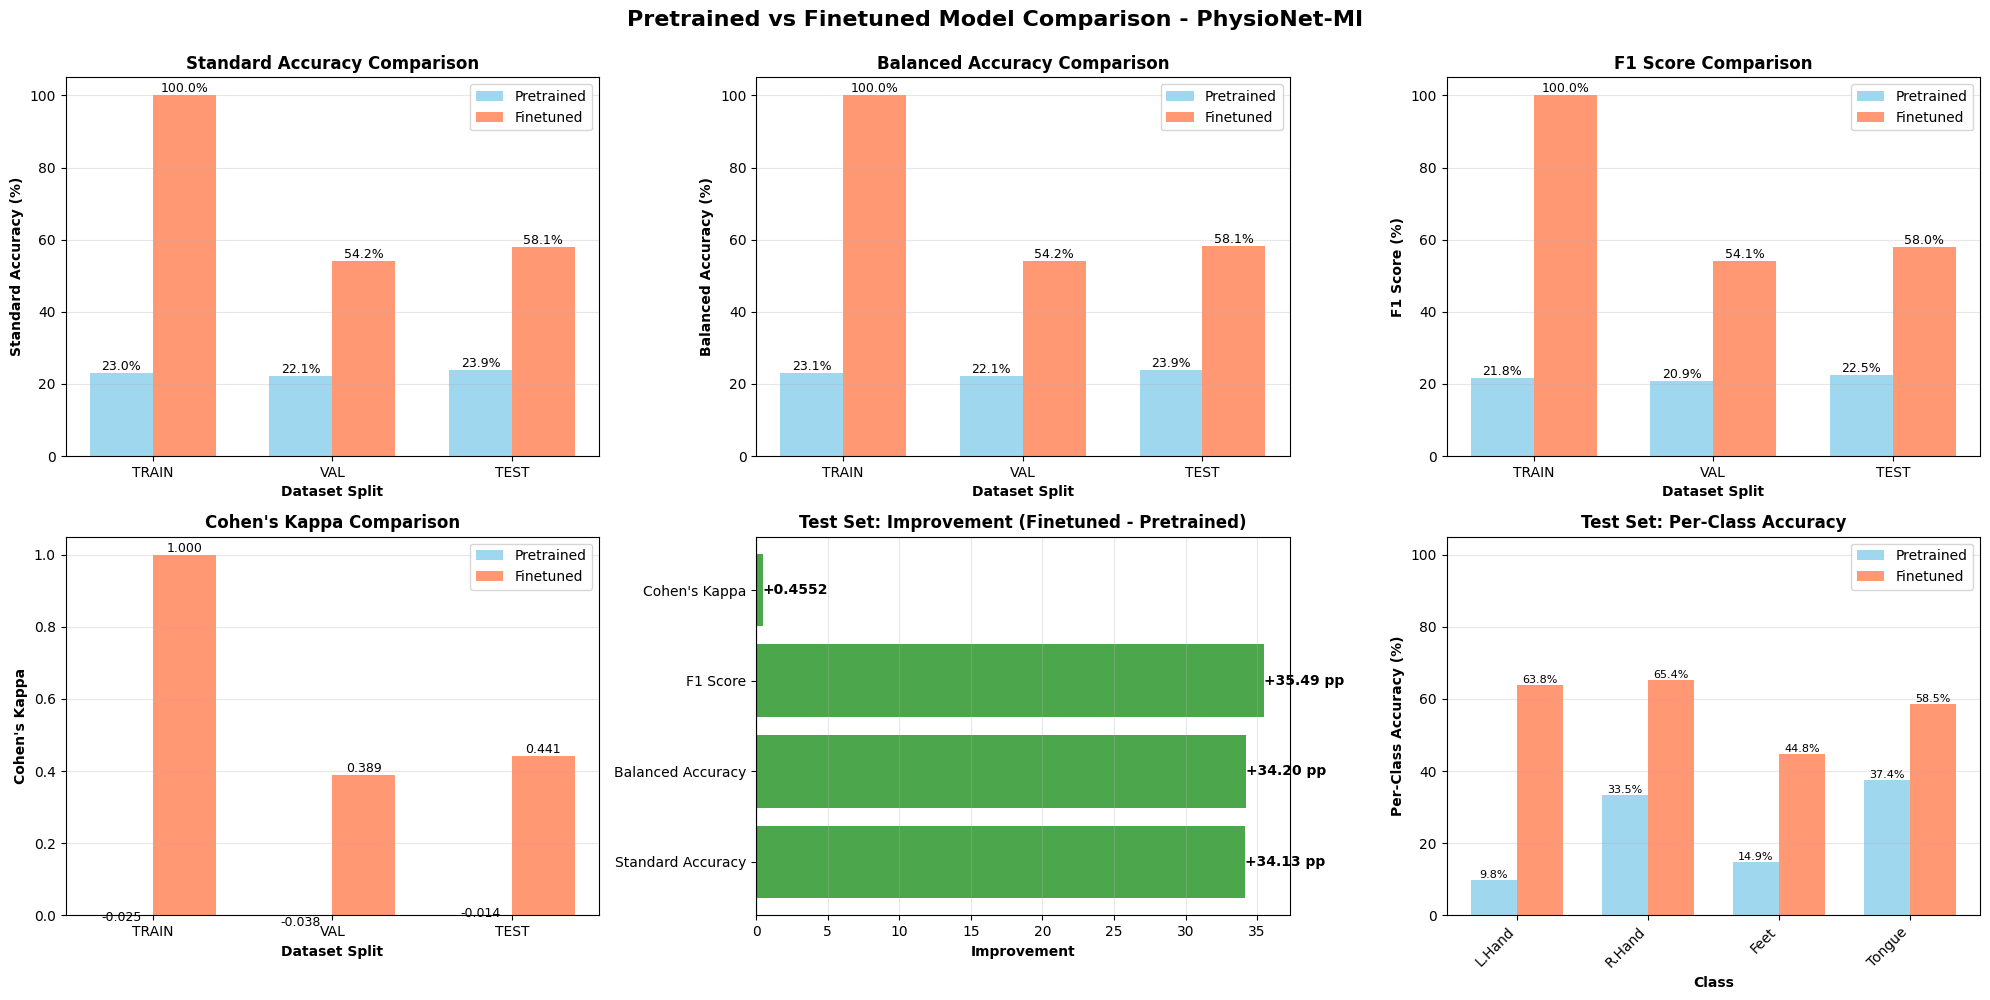


🎯 KEY INSIGHTS:
  • Test Set Standard Accuracy: 23.95% → 58.08% (+34.13 pp)
  • Relative Improvement: +142.5%
  • ✅ Finetuning improved performance by 34.13 percentage points!


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def compare_results(pretrained_results, finetuned_results):
    """
    Compare pretrained and finetuned model results with visualizations
    """
    
    print("="*80)
    print("📊 PRETRAINED vs FINETUNED MODEL COMPARISON")
    print("="*80)
    
    # Comparison table
    print("\n📈 Performance Comparison Table:")
    print("-"*80)
    print(f"{'Metric':<25} {'Split':<10} {'Pretrained':<15} {'Finetuned':<15} {'Improvement'}")
    print("-"*80)
    
    metrics = [
        ('standard_accuracy', 'Standard Accuracy', '%'),
        ('balanced_accuracy', 'Balanced Accuracy', '%'),
        ('f1', 'F1 Score', '%'),
        ('kappa', 'Cohen\'s Kappa', '')
    ]
    
    for split_name in ['train', 'val', 'test']:
        if split_name in pretrained_results and split_name in finetuned_results:
            print(f"\n{split_name.upper()} SET:")
            for metric_key, metric_name, unit in metrics:
                pre_val = pretrained_results[split_name][metric_key]
                ft_val = finetuned_results[split_name][metric_key]
                
                if unit == '%':
                    pre_str = f"{pre_val*100:6.2f}%"
                    ft_str = f"{ft_val*100:6.2f}%"
                    imp = (ft_val - pre_val) * 100
                    imp_str = f"{imp:+6.2f} pp" if imp != 0 else "  --"
                else:
                    pre_str = f"{pre_val:6.4f}"
                    ft_str = f"{ft_val:6.4f}"
                    imp = ft_val - pre_val
                    imp_str = f"{imp:+6.4f}" if imp != 0 else "  --"
                
                print(f"  {metric_name:<23} {split_name:<10} {pre_str:<15} {ft_str:<15} {imp_str}")
    
    print("\n" + "="*80)
    
    # Create comparison visualizations
    fig = plt.figure(figsize=(20, 10))
    
    splits = ['train', 'val', 'test']
    x = np.arange(len(splits))
    width = 0.35
    
    # 1. Standard Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    pre_acc = [pretrained_results[s]['standard_accuracy']*100 for s in splits if s in pretrained_results]
    ft_acc = [finetuned_results[s]['standard_accuracy']*100 for s in splits if s in finetuned_results]
    
    bars1 = ax1.bar(x - width/2, pre_acc, width, label='Pretrained', color='skyblue', alpha=0.8)
    bars2 = ax1.bar(x + width/2, ft_acc, width, label='Finetuned', color='coral', alpha=0.8)
    
    ax1.set_xlabel('Dataset Split', fontweight='bold')
    ax1.set_ylabel('Standard Accuracy (%)', fontweight='bold')
    ax1.set_title('Standard Accuracy Comparison', fontweight='bold', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels([s.upper() for s in splits])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim([0, 105])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. Balanced Accuracy Comparison
    ax2 = plt.subplot(2, 3, 2)
    pre_bal = [pretrained_results[s]['balanced_accuracy']*100 for s in splits if s in pretrained_results]
    ft_bal = [finetuned_results[s]['balanced_accuracy']*100 for s in splits if s in finetuned_results]
    
    bars1 = ax2.bar(x - width/2, pre_bal, width, label='Pretrained', color='skyblue', alpha=0.8)
    bars2 = ax2.bar(x + width/2, ft_bal, width, label='Finetuned', color='coral', alpha=0.8)
    
    ax2.set_xlabel('Dataset Split', fontweight='bold')
    ax2.set_ylabel('Balanced Accuracy (%)', fontweight='bold')
    ax2.set_title('Balanced Accuracy Comparison', fontweight='bold', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels([s.upper() for s in splits])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, 105])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. F1 Score Comparison
    ax3 = plt.subplot(2, 3, 3)
    pre_f1 = [pretrained_results[s]['f1']*100 for s in splits if s in pretrained_results]
    ft_f1 = [finetuned_results[s]['f1']*100 for s in splits if s in finetuned_results]
    
    bars1 = ax3.bar(x - width/2, pre_f1, width, label='Pretrained', color='skyblue', alpha=0.8)
    bars2 = ax3.bar(x + width/2, ft_f1, width, label='Finetuned', color='coral', alpha=0.8)
    
    ax3.set_xlabel('Dataset Split', fontweight='bold')
    ax3.set_ylabel('F1 Score (%)', fontweight='bold')
    ax3.set_title('F1 Score Comparison', fontweight='bold', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels([s.upper() for s in splits])
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim([0, 105])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 4. Kappa Score Comparison
    ax4 = plt.subplot(2, 3, 4)
    pre_kappa = [pretrained_results[s]['kappa'] for s in splits if s in pretrained_results]
    ft_kappa = [finetuned_results[s]['kappa'] for s in splits if s in finetuned_results]
    
    bars1 = ax4.bar(x - width/2, pre_kappa, width, label='Pretrained', color='skyblue', alpha=0.8)
    bars2 = ax4.bar(x + width/2, ft_kappa, width, label='Finetuned', color='coral', alpha=0.8)
    
    ax4.set_xlabel('Dataset Split', fontweight='bold')
    ax4.set_ylabel('Cohen\'s Kappa', fontweight='bold')
    ax4.set_title('Cohen\'s Kappa Comparison', fontweight='bold', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels([s.upper() for s in splits])
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim([0, 1.05])
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Improvement Heatmap (Test Set)
    ax5 = plt.subplot(2, 3, 5)
    if 'test' in pretrained_results and 'test' in finetuned_results:
        improvements = []
        metric_labels = []
        
        for metric_key, metric_name, unit in metrics:
            pre_val = pretrained_results['test'][metric_key]
            ft_val = finetuned_results['test'][metric_key]
            
            if unit == '%':
                imp = (ft_val - pre_val) * 100  # percentage points
            else:
                imp = ft_val - pre_val
            
            improvements.append(imp)
            metric_labels.append(metric_name)
        
        colors = ['green' if imp > 0 else 'red' for imp in improvements]
        bars = ax5.barh(metric_labels, improvements, color=colors, alpha=0.7)
        
        ax5.set_xlabel('Improvement', fontweight='bold')
        ax5.set_title('Test Set: Improvement (Finetuned - Pretrained)', fontweight='bold', fontsize=12)
        ax5.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax5.grid(axis='x', alpha=0.3)
        
        for i, (bar, imp) in enumerate(zip(bars, improvements)):
            label = f'{imp:+.2f} pp' if i < 3 else f'{imp:+.4f}'
            ax5.text(imp, bar.get_y() + bar.get_height()/2, label,
                    ha='left' if imp > 0 else 'right', va='center', fontweight='bold')
    
    # 6. Confusion Matrix Comparison (Test Set)
    ax6 = plt.subplot(2, 3, 6)
    if 'test' in pretrained_results and 'test' in finetuned_results:
        pre_cm = pretrained_results['test']['confusion_matrix']
        ft_cm = finetuned_results['test']['confusion_matrix']
        
        # Calculate per-class accuracy for both models
        class_names = ['L.Hand', 'R.Hand', 'Feet', 'Tongue']
        pre_class_acc = [pre_cm[i,i] / pre_cm[i,:].sum() * 100 if pre_cm[i,:].sum() > 0 else 0 
                         for i in range(len(class_names))]
        ft_class_acc = [ft_cm[i,i] / ft_cm[i,:].sum() * 100 if ft_cm[i,:].sum() > 0 else 0 
                        for i in range(len(class_names))]
        
        x_pos = np.arange(len(class_names))
        bars1 = ax6.bar(x_pos - width/2, pre_class_acc, width, label='Pretrained', color='skyblue', alpha=0.8)
        bars2 = ax6.bar(x_pos + width/2, ft_class_acc, width, label='Finetuned', color='coral', alpha=0.8)
        
        ax6.set_xlabel('Class', fontweight='bold')
        ax6.set_ylabel('Per-Class Accuracy (%)', fontweight='bold')
        ax6.set_title('Test Set: Per-Class Accuracy', fontweight='bold', fontsize=12)
        ax6.set_xticks(x_pos)
        ax6.set_xticklabels(class_names, rotation=45, ha='right')
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
        ax6.set_ylim([0, 105])
        
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax6.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Pretrained vs Finetuned Model Comparison - PhysioNet-MI', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n🎯 KEY INSIGHTS:")
    if 'test' in pretrained_results and 'test' in finetuned_results:
        pre_test_acc = pretrained_results['test']['standard_accuracy'] * 100
        ft_test_acc = finetuned_results['test']['standard_accuracy'] * 100
        improvement = ft_test_acc - pre_test_acc
        
        print(f"  • Test Set Standard Accuracy: {pre_test_acc:.2f}% → {ft_test_acc:.2f}% ({improvement:+.2f} pp)")
        print(f"  • Relative Improvement: {(improvement/pre_test_acc)*100:+.1f}%")
        
        if improvement > 0:
            print(f"  • ✅ Finetuning improved performance by {improvement:.2f} percentage points!")
        else:
            print(f"  • ⚠️ Finetuning decreased performance by {abs(improvement):.2f} percentage points")


# Run comparison if both results exist
if 'pretrained_results' in locals() and 'finetuned_results' in locals():
    print("🔍 Both result sets found! Running comparison...\n")
    compare_results(pretrained_results, finetuned_results)
else:
    print("⚠️ Please run both evaluation examples above first:")
    if 'pretrained_results' not in locals():
        print("  ❌ 'pretrained_results' not found - run Example 1")
    if 'finetuned_results' not in locals():
        print("  ❌ 'finetuned_results' not found - run Example 2")
    print("\n💡 Then run this cell again to see the comparison.")